In [69]:
import pandas as pd
from keras.models import load_model
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import numpy as np
from utils import load_and_label_data
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

# 3. Evaluation

In this notebook, we evaluate our results from our experiments in _2_training_. To achieve this, we first load our data.

In [109]:
data = pd.read_csv("data.csv")
data = data.assign(label=data["plant"] + "$" + data["disease"])

train = pd.DataFrame()
test = pd.DataFrame()
for label in data["label"].unique():
    data_for_label = data[data["label"] == label].reset_index(drop=True)

    # all data
    train_current_label, rest = train_test_split(data_for_label, test_size=0.1)
    test_current_label, _ = train_test_split(rest, test_size=0.5)

    train = pd.concat([train, train_current_label])
    test = pd.concat([test, test_current_label])

train = shuffle(train, random_state=42)
test = shuffle(test, random_state=42)
print(len(test))

2716


Our test set consists of 2,716 samples. Let's load prepare our data for prediction.

In [90]:
X_test, y_test = load_and_label_data(test)

In [92]:
encoder = OneHotEncoder(sparse_output=False)

encoder.fit(np.array(train["label"]).reshape(-1, 1))
y_test_encoded = encoder.transform(np.array(y_test).reshape(-1, 1))

We start by evaluating our "vanilla CNN" that was trained on the whole dataset.

In [93]:
model = load_model("models/all.h5")

y_pred = model.predict(np.array(X_test))

85/85 [==============================] - 19s 209ms/step


                                             precision    recall  f1-score   support

                           Apple$Apple_scab       0.96      0.84      0.90        31
                            Apple$Black_rot       1.00      0.90      0.95        31
                     Apple$Cedar_apple_rust       1.00      0.93      0.96        14
                              Apple$healthy       0.99      0.90      0.94        82
                          Blueberry$healthy       0.94      0.97      0.95        75
                      Cherry$Powdery_mildew       0.98      0.98      0.98        53
                             Cherry$healthy       0.91      1.00      0.96        43
   Corn$Cercospora_leaf_spot Gray_leaf_spot       0.77      0.77      0.77        26
                           Corn$Common_rust       1.00      0.98      0.99        60
                  Corn$Northern_Leaf_Blight       0.88      0.88      0.88        49
                               Corn$healthy       0.98      1.00

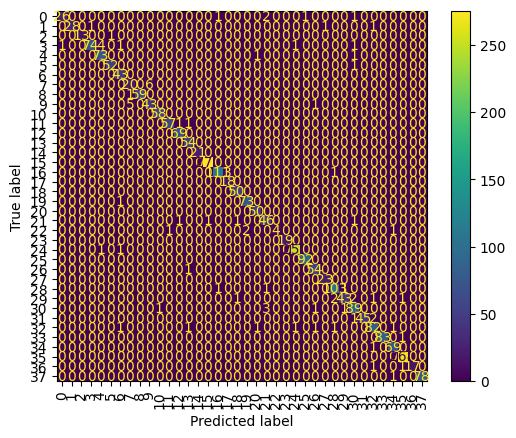

In [94]:
y_pred_decoded = encoder.inverse_transform(y_pred)
print(classification_report(y_test, y_pred_decoded))
cm = confusion_matrix(y_test, y_pred_decoded)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(xticks_rotation=90)
plt.show()

0.97 accuracy without any hyperparameter tuning seems already pretty good. Based on the classification report, we note that the model achieves the worst f1-score for the class that has the lowest support, healthy potatoes. Furthermore, we note that despite from an f1-score of 0.77 for corns with a gray leaf spot, our model achieves an f1-score > 0.9 for all other classes. <br> <br> 
Now, let's look at some of the details of our predictions.

In [113]:
false_predictions = pd.DataFrame()

for idx in range(len(X_test)):
    if y_pred_decoded[idx] != y_test[idx]:
        pred_split = y_pred_decoded[idx][0].split("$")
        test_split = y_test[idx].split("$")
        false_predictions = pd.concat(
            [
                false_predictions,
                pd.DataFrame(
                    {
                        "plant_pred": [pred_split[0]],
                        "plant_true": [test_split[0]],
                        "disease_pred": [pred_split[1]],
                        "disease_true": [test_split[1]],
                    }
                ),
            ]
        )

        # plt.imshow(X_test[idx])
        # plt.axis("off")
        # plt.suptitle(f"Predicted label: {y_pred_decoded[idx]}, actual label: {y_test[idx]}")
        # plt.show()

true_plant = false_predictions[
    false_predictions["plant_pred"] == false_predictions["plant_true"]
]
true_disease = false_predictions[
    false_predictions["disease_pred"] == false_predictions["disease_true"]
]
print(
    f"From {len(false_predictions)} false predictions, in {len(true_plant)}, the plant was correctly identified. In {len(true_disease)} cases, the disease was correct."
)
display(true_plant["plant_pred"].value_counts())
display(true_disease["disease_pred"].value_counts())

From 82 false predictions, in 37, the plant was correctly identified. In 17 cases, the disease was correct.


plant_pred
Tomato    18
Corn      12
Peach      3
Apple      2
Grape      2
Name: count, dtype: int64

disease_pred
healthy           11
Late_blight        4
Bacterial_spot     2
Name: count, dtype: int64

In 37 + 17 = 54 out of 82 false predictions (~65%), our model identified either the plant or the disease correctly. When the plant was correctly classified, our model seemed to have problems with different diseases of tomatoes and corn. When the "disease" was correctly classified, it seems that our model had the biggest problem to distinguish between different kinds of healthy leaves. <br> <br>
Let's look at some of these images. Starting with tomatoes

In [127]:
wrongly_classified_tomato_diseases = false_predictions[
    (false_predictions["plant_pred"].str.startswith("Tomato"))
    & (false_predictions["plant_true"].str.startswith("Tomato"))
]
display(wrongly_classified_tomato_diseases)
display(wrongly_classified_tomato_diseases["disease_true"].value_counts())

plant_pred plant_true                   disease_pred  \
0     Tomato     Tomato  Tomato_Yellow_Leaf_Curl_Virus   
0     Tomato     Tomato             Septoria_leaf_spot   
0     Tomato     Tomato                    Target_Spot   
0     Tomato     Tomato             Septoria_leaf_spot   
0     Tomato     Tomato                    Target_Spot   
0     Tomato     Tomato                 Bacterial_spot   
0     Tomato     Tomato  Tomato_Yellow_Leaf_Curl_Virus   
0     Tomato     Tomato                   Early_blight   
0     Tomato     Tomato             Septoria_leaf_spot   
0     Tomato     Tomato                    Late_blight   
0     Tomato     Tomato  Tomato_Yellow_Leaf_Curl_Virus   
0     Tomato     Tomato                    Late_blight   
0     Tomato     Tomato                    Late_blight   
0     Tomato     Tomato                 Bacterial_spot   
0     Tomato     Tomato             Septoria_leaf_spot   
0     Tomato     Tomato                 Bacterial_spot   
0     Tomato     Tomato                   Early_blight   
0     Tomato     Tomato             Septoria_leaf_spot   

                           disease_true  
0                          Early_blight  
0                           Target_Spot  
0                               healthy  
0                             Leaf_Mold  
0                    Septoria_leaf_spot  
0                          Early_blight  
0                   Tomato_mosaic_virus  
0                        Bacterial_spot  
0                   Tomato_mosaic_virus  
0                          Early_blight  
0  Spider_mites Two-spotted_spider_mite  
0                             Leaf_Mold  
0                          Early_blight  
0                          Early_blight  
0                          Early_blight  
0                    Septoria_leaf_spot  
0                           Late_blight  
0                             Leaf_Mold

disease_true
Early_blight                            6
Leaf_Mold                               3
Septoria_leaf_spot                      2
Tomato_mosaic_virus                     2
Target_Spot                             1
healthy                                 1
Bacterial_spot                          1
Spider_mites Two-spotted_spider_mite    1
Late_blight                             1
Name: count, dtype: int64

Looking at wrongly classified tomato diseases, we note that our model commonly confuses early blight. Let's look at some example images

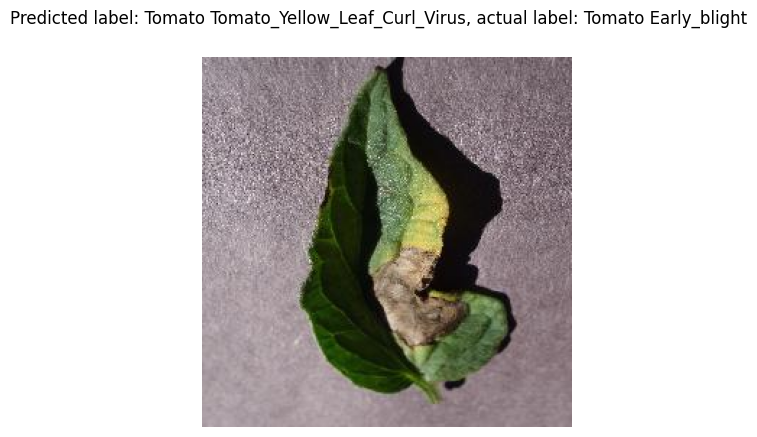

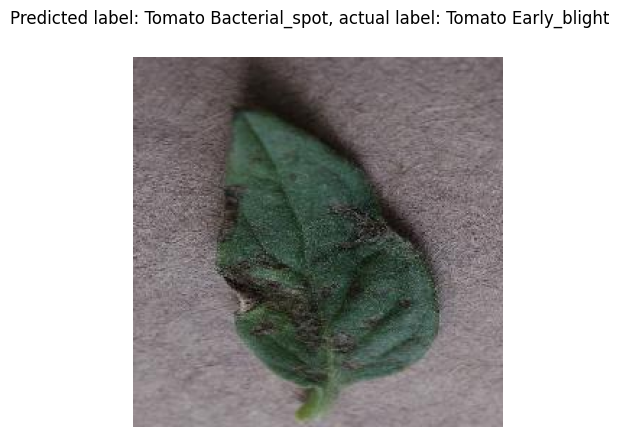

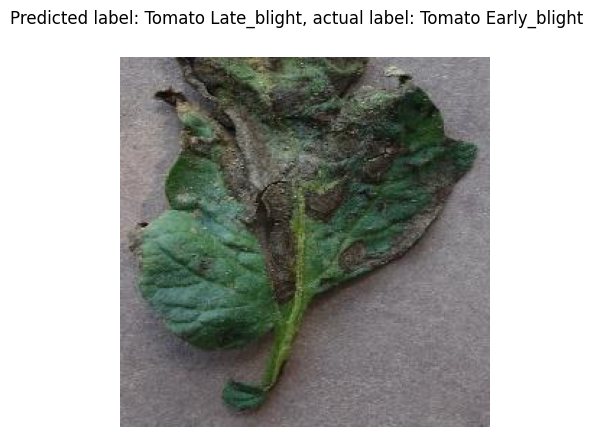

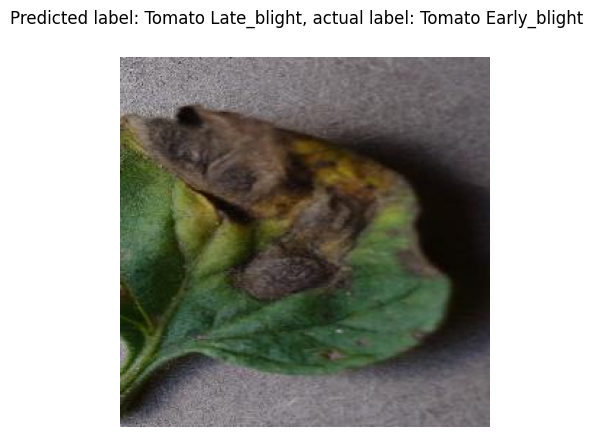

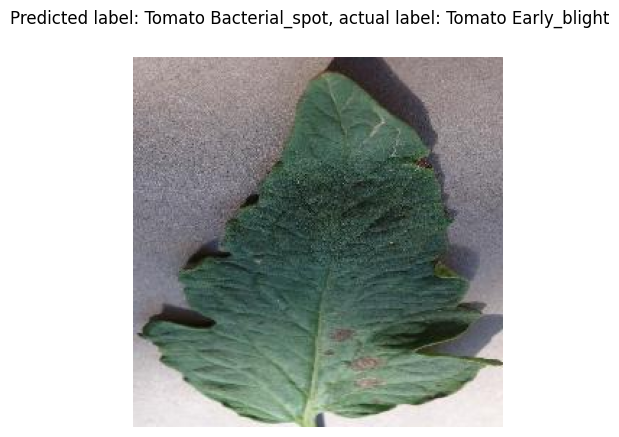

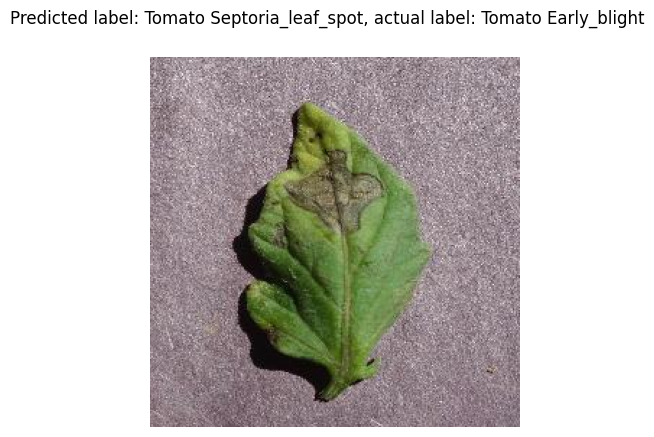

In [129]:
for idx in range(len(X_test)):
    if y_pred_decoded[idx] != y_test[idx]:
        if (
            y_pred_decoded[idx][0].startswith("Tomato")
            and y_test[idx].startswith("Tomato")
            and y_test[idx].endswith("Early_blight")
        ):
            plt.imshow(X_test[idx])
            plt.axis("off")
            plt.suptitle(
                f"Predicted label: {y_pred_decoded[idx][0].replace('$', ' ')}, actual label: {y_test[idx].replace('$', ' ')}"
            )
            plt.show()

Based on these images, we conclude that it can be hard for our model to distinguish between the different diseases. For further improvements of the model, one might consider "artificially" increasing the support of images of tomato leaves with early blight, as it has a relatively low support (50) when compared against late blight (95) and a bacterial spot (106). This could be done by, e.g., flipping existing images.

Next, we look at wrongly classified corn.

In [131]:
wrongly_classified_corn_diseases = false_predictions[
    (false_predictions["plant_pred"].str.startswith("Corn"))
    & (false_predictions["plant_true"].str.startswith("Corn"))
]
display(wrongly_classified_corn_diseases)
display(wrongly_classified_corn_diseases["disease_true"].value_counts())

plant_pred plant_true                         disease_pred  \
0       Corn       Corn  Cercospora_leaf_spot Gray_leaf_spot   
0       Corn       Corn  Cercospora_leaf_spot Gray_leaf_spot   
0       Corn       Corn                 Northern_Leaf_Blight   
0       Corn       Corn                 Northern_Leaf_Blight   
0       Corn       Corn                 Northern_Leaf_Blight   
0       Corn       Corn  Cercospora_leaf_spot Gray_leaf_spot   
0       Corn       Corn  Cercospora_leaf_spot Gray_leaf_spot   
0       Corn       Corn                 Northern_Leaf_Blight   
0       Corn       Corn  Cercospora_leaf_spot Gray_leaf_spot   
0       Corn       Corn                 Northern_Leaf_Blight   
0       Corn       Corn  Cercospora_leaf_spot Gray_leaf_spot   
0       Corn       Corn                 Northern_Leaf_Blight   

                          disease_true  
0                 Northern_Leaf_Blight  
0                          Common_rust  
0  Cercospora_leaf_spot Gray_leaf_spot  
0  Cercospora_leaf_spot Gray_leaf_spot  
0  Cercospora_leaf_spot Gray_leaf_spot  
0                 Northern_Leaf_Blight  
0                 Northern_Leaf_Blight  
0  Cercospora_leaf_spot Gray_leaf_spot  
0                 Northern_Leaf_Blight  
0  Cercospora_leaf_spot Gray_leaf_spot  
0                 Northern_Leaf_Blight  
0  Cercospora_leaf_spot Gray_leaf_spot

disease_true
Cercospora_leaf_spot Gray_leaf_spot    6
Northern_Leaf_Blight                   5
Common_rust                            1
Name: count, dtype: int64

Okay, our model commonly confuses gray leaf spots with northern leaf blight. Let's look at some images.

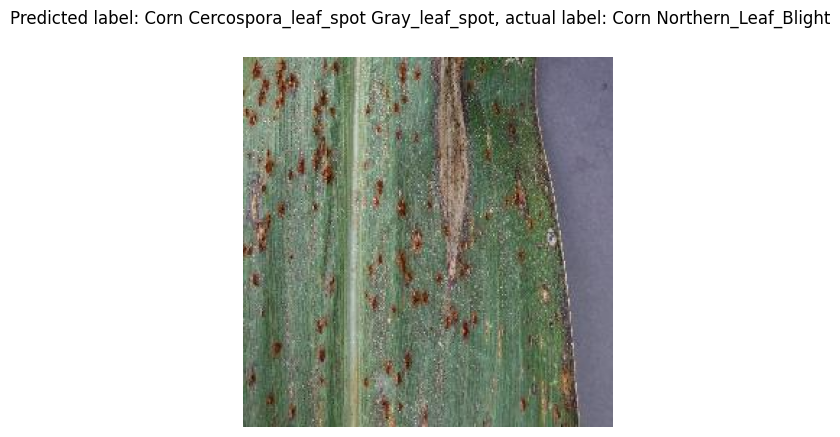

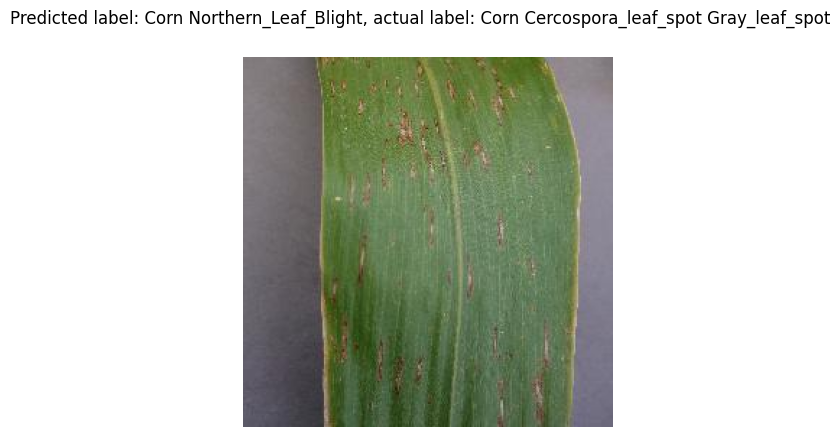

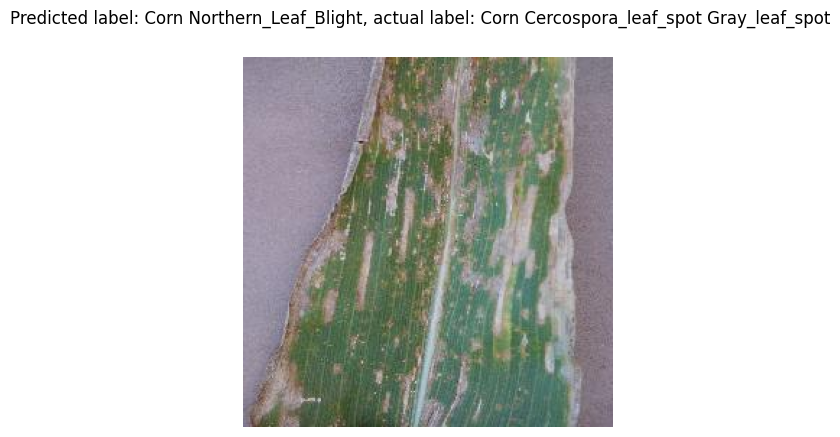

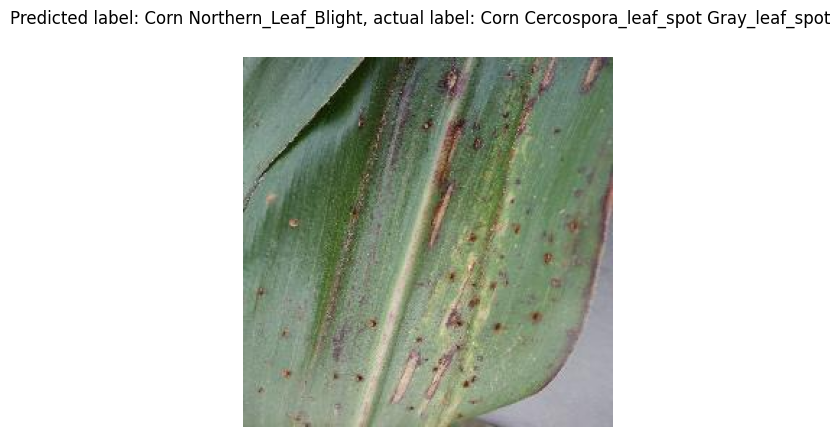

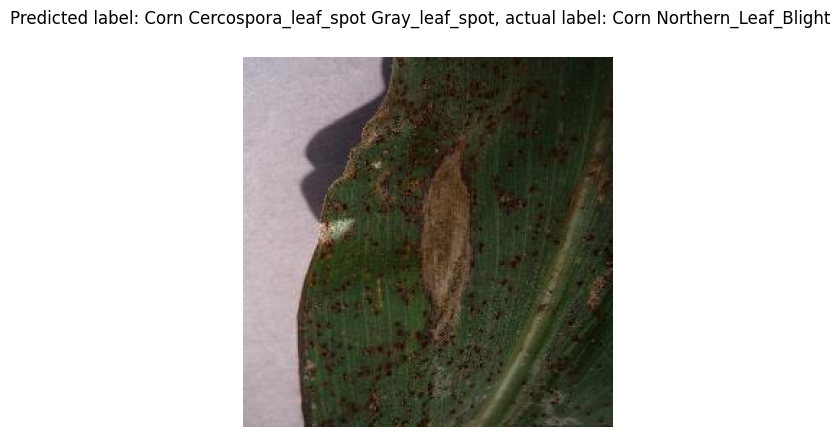

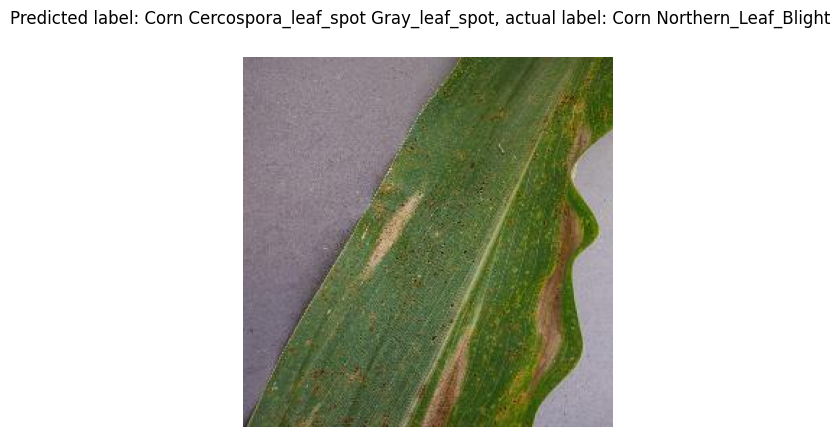

In [134]:
count_cerco = 0
count_northern = 0
show = False
for idx in range(len(X_test)):
    if y_pred_decoded[idx] != y_test[idx]:
        if y_pred_decoded[idx][0].startswith("Corn") and y_test[idx].startswith("Corn"):
            if (
                y_test[idx].endswith("Cercospora_leaf_spot Gray_leaf_spot")
                and count_cerco < 3
            ):
                count_cerco += 1
                show = True
            if y_test[idx].endswith("Northern_Leaf_Blight") and count_northern < 3:
                count_northern += 1
                show = True
            if show == True:
                plt.imshow(X_test[idx])
                plt.axis("off")
                plt.suptitle(
                    f"Predicted label: {y_pred_decoded[idx][0].replace('$', ' ')}, actual label: {y_test[idx].replace('$', ' ')}"
                )
                plt.show()
                show = False

Even as a human, these diseases look similar (disclaimer: opinionated), and it can be hard for the model to distinguish between one another. <br> <br> 

The most common "disease" that was misclassified were healthy leaves. Let's also take a look into these misclassified samples.

In [136]:
wrongly_classified_healthy_leaves = false_predictions[
    (false_predictions["disease_pred"] == "healthy")
    & (false_predictions["disease_true"] == "healthy")
]
display(wrongly_classified_healthy_leaves)

plant_pred    plant_true disease_pred disease_true
0  Pepper,_bell        Potato      healthy      healthy
0        Cherry  Pepper,_bell      healthy      healthy
0     Blueberry         Apple      healthy      healthy
0       Soybean         Apple      healthy      healthy
0        Cherry       Soybean      healthy      healthy
0     Blueberry       Soybean      healthy      healthy
0     Blueberry         Apple      healthy      healthy
0  Pepper,_bell        Potato      healthy      healthy
0     Blueberry         Apple      healthy      healthy
0     Blueberry         Apple      healthy      healthy
0        Cherry         Apple      healthy      healthy

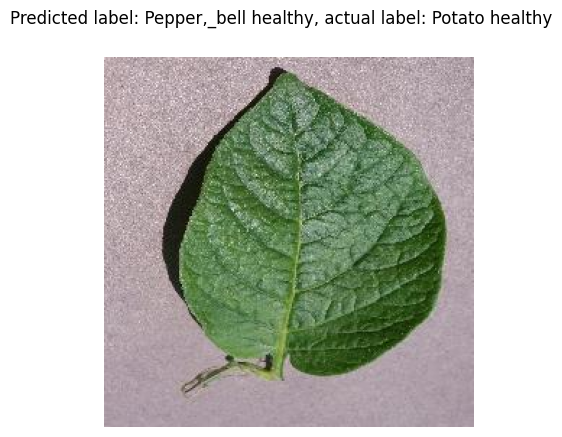

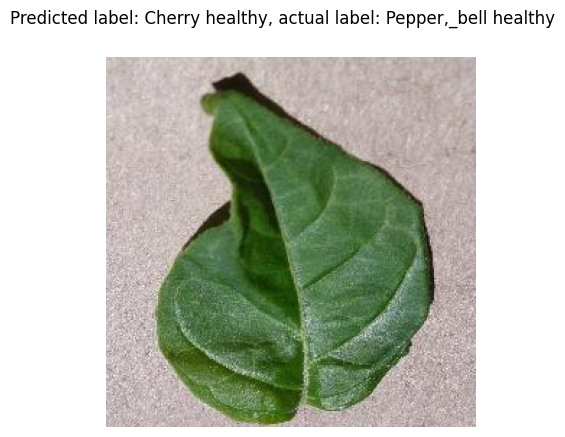

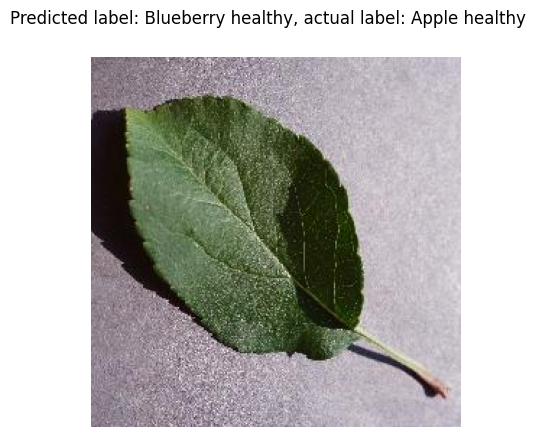

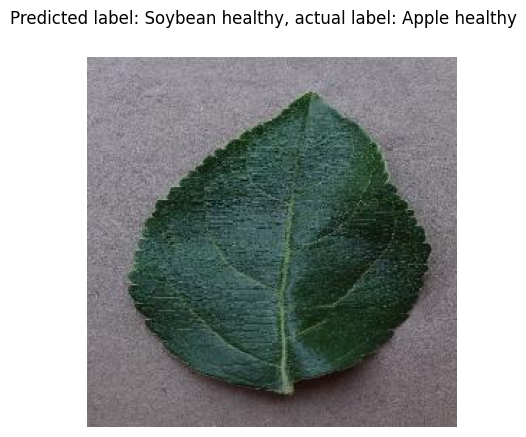

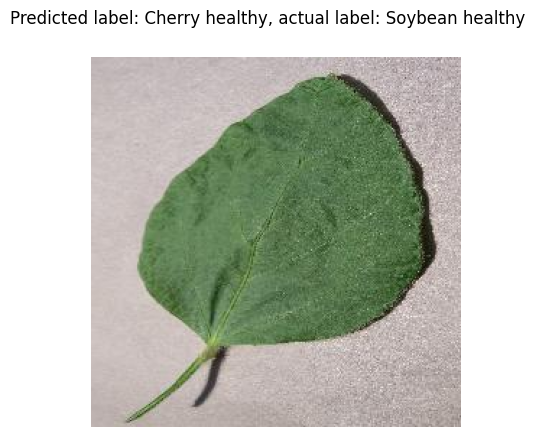

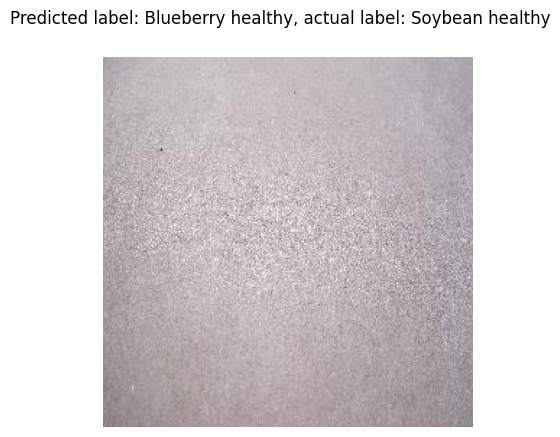

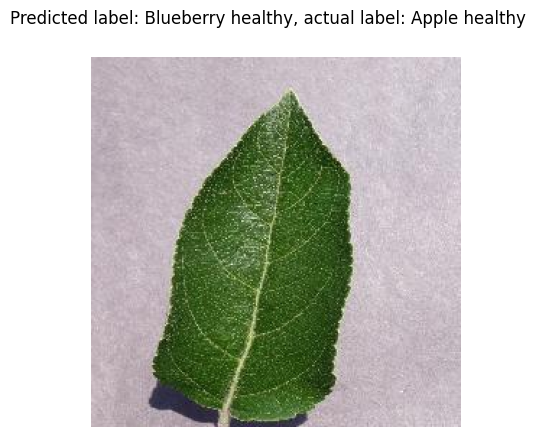

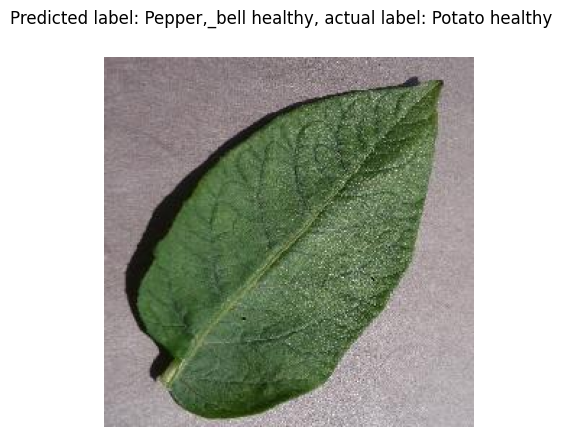

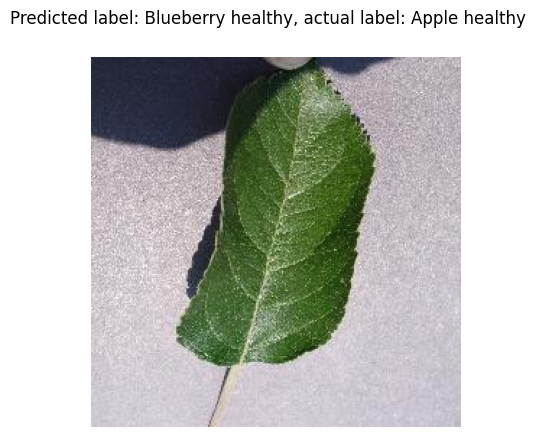

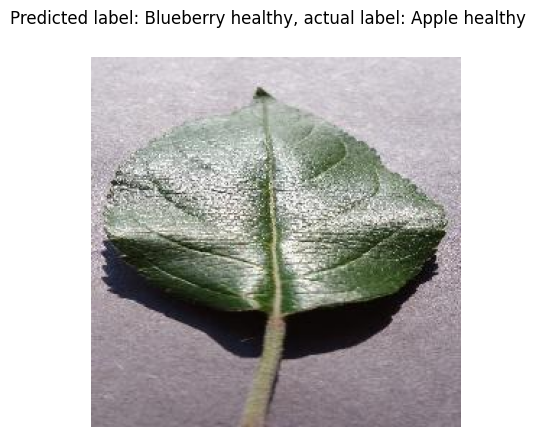

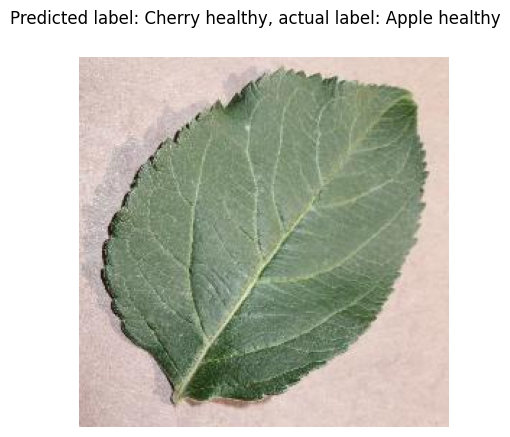

In [140]:
for idx in range(len(X_test)):
    if y_pred_decoded[idx] != y_test[idx]:
        if y_pred_decoded[idx][0].endswith("healthy") and y_test[idx].endswith(
            "healthy"
        ):
            plt.imshow(X_test[idx])
            plt.axis("off")
            plt.suptitle(
                f"Predicted label: {y_pred_decoded[idx][0].replace('$', ' ')}, actual label: {y_test[idx].replace('$', ' ')}"
            )
            plt.show()

We note that there is one image that does not contain any leaf. Other than that, similar to the wrongly predicted diseases, some of the leaves are hard to distinguish, even for humans. With this, we conclude the evaluation of our first model. To summarize:
- 0.97 is already a good score
- out of the wrongly classified images, many of the respective diseases / plants look similar
- the dataset still contains at least one image that we consider as noise, since it does not show anything